In [51]:
!pip install mplfinance
!pip install yfinance


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# ------------------------------
# CONFIG
# ------------------------------
COMPANY = "CBA.AX"              # ticker here 
START = "2020-01-01"       # Start date to read
END = "2023-08-01"         # End date to read
TEST_SIZE = 0.2
TIME_STEP = 60
FUTURE_DAYS = 10

# === Saving options ===
SAVE_TO_DRIVE = False  # set True if running in Google Colab with Drive mounted
DRIVE_PATH = "https://drive.google.com/drive/folders/1I9YUham69toMdBusIAJ9l3fvXBE0gQfC" 

# Create save directory
def make_save_dir():
    if SAVE_TO_DRIVE:
        try:
            os.makedirs(DRIVE_PATH, exist_ok=True)
            return DRIVE_PATH
        except Exception as e:
            print("Could not create Drive folder, saving locally instead:", e)
            
    os.makedirs("./outputs", exist_ok=True)
    return "./outputs"

SAVE_DIR = make_save_dir()

In [ ]:
def fetch_prices(ticker, start, end):
    df = yf.download(ticker, start=start, end=end, progress=False)
    if df.empty:
        raise ValueError(f"No data returned for {ticker}.")

    # Flatten MultiIndex: keep only the first level
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Clean up whitespace
    df.columns = [c.strip() for c in df.columns]

    # If "Adj Close" exists, use it as "Close"
    if "Adj Close" in df.columns and "Close" not in df.columns:
        df = df.rename(columns={"Adj Close": "Close"})

    print("Columns after cleaning:", df.columns.tolist())
    return df


In [55]:
def scale_close_series(df):
    data = df[["Close"]].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled, scaler

def make_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [63]:
def plot_candlestick(df, ticker):
    mpf.plot(
        df,
        type="candle",
        volume=True,
        style="yahoo",
        title=f"{ticker} Candlestick"
    )

def plot_high_low(df, ticker):
    plt.figure(figsize=(12,6))
    plt.plot(df["High"], label="High", linewidth=1.2)
    plt.plot(df["Low"], label="Low", linewidth=1.2)
    plt.title(f"{ticker} High & Low Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

def plot_true_vs_pred(ticker, true_prices, pred_prices):
    plt.figure(figsize=(12,6))
    plt.plot(true_prices, label=f"Actual {ticker} Price", linewidth=1.2)
    plt.plot(pred_prices, label=f"Predicted {ticker} Price", linewidth=1.2)
    plt.title(f"{ticker} True vs Predicted Prices (10-day forecast)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [64]:
def save_csvs(ticker, df_hist, pred_array):
    hist_path = os.path.join(SAVE_DIR, f"{ticker}_historical.csv")
    pred_path = os.path.join(SAVE_DIR, f"{ticker}_predictions.csv")
    df_hist.to_csv(hist_path)
    pd.DataFrame(pred_array, columns=["Predicted"]).to_csv(pred_path, index=False)
    print(f"Saved historical CSV: {hist_path}")
    print(f"Saved predictions CSV: {pred_path}")


Processing CBA.AX
Columns after cleaning: ['Close', 'High', 'Low', 'Open', 'Volume']


C:\Users\ishan\AppData\Local\Temp\ipykernel_31836\663076503.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


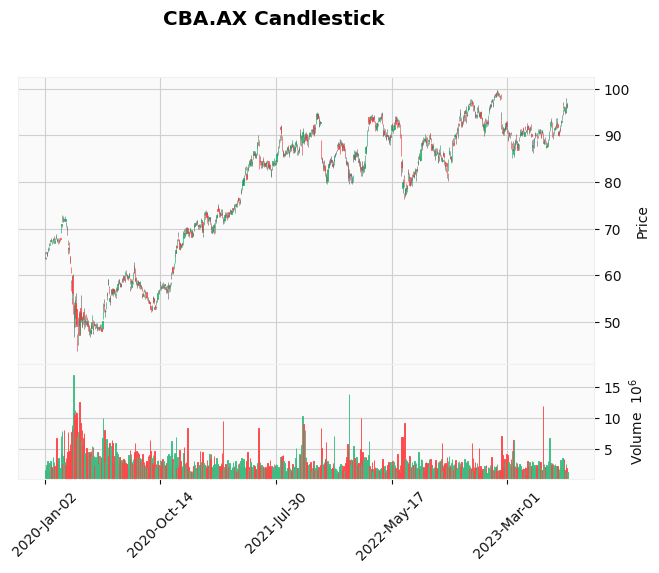

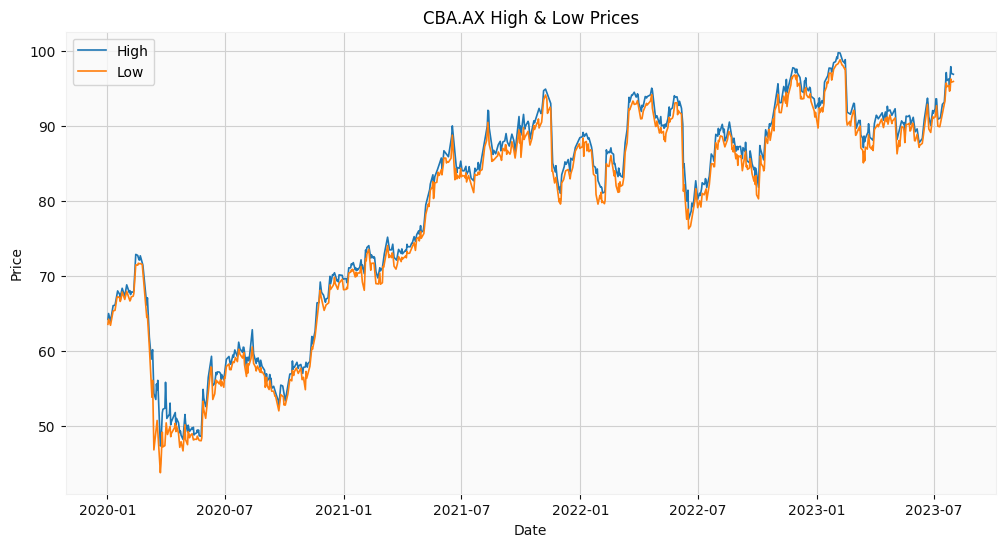

Epoch 1/24


c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
CBA.AX RMSE: 1.9865
CBA.AX MAE: 1.5142


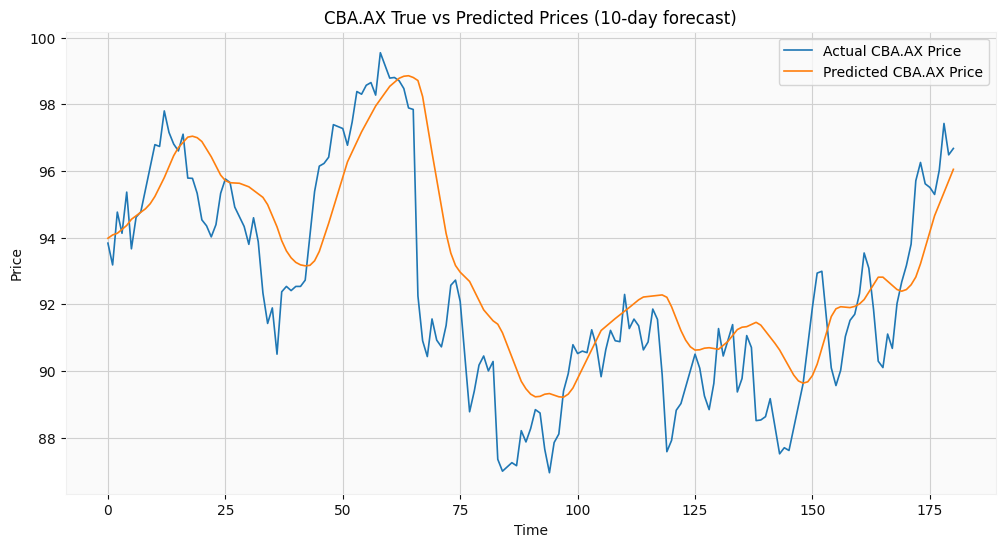

Saved historical CSV: ./outputs\CBA.AX_historical.csv
Saved predictions CSV: ./outputs\CBA.AX_predictions.csv

Done.


In [68]:
print("\n============================")
print(f"Processing {COMPANY}")
print("============================")

# 1) Get data
df = fetch_prices(COMPANY, START, END)

# 2) Candlestick 
plot_candlestick(df, COMPANY)

# 3) High & Low 
plot_high_low(df, COMPANY)

# 4) Prepare data for LSTM
scaled, scaler = scale_close_series(df)
cut = int(len(scaled) * (1 - TEST_SIZE))
train = scaled[:cut]
test  = scaled[cut - TIME_STEP:]

X_train, y_train = make_sequences(train, TIME_STEP)
X_test,  y_test  = make_sequences(test, TIME_STEP)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 5) Train model 
model = build_lstm((TIME_STEP, 1))
model.fit(X_train, y_train, epochs=24, batch_size=32, verbose=0.1)

# 6) Predictions
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
true = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7) Metrics (RMSE & MAE)
rmse = np.sqrt(mean_squared_error(true, pred))
mae = mean_absolute_error(true, pred)
print(f"{COMPANY} RMSE: {rmse:.4f}")
print(f"{COMPANY} MAE: {mae:.4f}")

# 8) Plot True vs Predicted 
plot_true_vs_pred(COMPANY, true, pred)

# 9) Future forecasts:
#    b) Full 10-day numeric list printed (friend's “10 upcoming days prediction” figure)
last_60 = scaled[-TIME_STEP:].reshape(1, TIME_STEP, 1)
future_scaled = []
cur = last_60.copy()

for _ in range(FUTURE_DAYS):
    next_scaled = model.predict(cur, verbose=0)[0, 0]
    future_scaled.append(next_scaled)
    # slide window
    cur = np.append(cur[:, 1:, :], [[[next_scaled]]], axis=1)


# b) Print 10 upcoming days prediction 
#print("\n10 upcoming days prediction:")
#for i, v in enumerate(future_vals, start=1):
    #print(f"Day +{i}: {v:.2f}")

# 10) Save CSVs
#     - historical prices
#     - predictions (for test set)
save_csvs(COMPANY, df, pred)

print("\nDone.")